## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from sklearn.feature_extraction.text import TfidfVectorizer  # For TF-IDF vectorization
from sklearn.linear_model import LogisticRegression  # For logistic regression classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score  # For evaluation metrics

import re
import string

import nltk  # Natural Language Toolkit, a library for natural language processing tasks.
from nltk.corpus import wordnet  # WordNet is a lexical database for English, used for synonym resolution and more.
from nltk.stem import WordNetLemmatizer  # Lemmatization is the process of reducing words to their base or root form.
from nltk.stem.porter import PorterStemmer  # Stemming is the process of reducing words to their stem or root form.
from nltk.corpus import stopwords  # Stopwords are common words that are often filtered out in natural language processing tasks.
from textblob import TextBlob  # TextBlob is a simple library for processing textual data.

from tqdm import tqdm

import contractions # Contractions library expands contractions in English text, e.g., "won't" to "will not".

import joblib

In [6]:
# Specify the encoding explicitly when reading the CSV file
df = pd.read_csv(r"C:\Users\suren\Downloads\NLP for Sentiment Analysis\Dataset\hate.csv", encoding='latin1')

# Display the first five rows of the DataFrame
df.head()

,Unnamed: 0,comment,label
0,1,dalits are lowlives,N
1,2,gay people are a burden to our society,N
2,3,Arabs are not welcome,N
3,4,I'm not saying we should actually eliminate he...,N
4,5,bananas are for black people,N


In [7]:
# drop "Unnamed: 0" column
df = df.drop("Unnamed: 0", axis=1)

In [8]:
# Display the first five rows of the DataFrame
df.head()

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N


In [9]:
# diplay the shape of dataset (row & column)
df.shape

(41144, 2)

### Dataset have:
*     2: columns  
*     41144: rows

In [10]:
# checking the unique label from label column
df['label'].unique()

array(['N', 'P', 'O'], dtype=object)

### Dataset have three Sentiment:
* N: Negative Sentiment
* P: Positive Sentiment
* O: Neutral Sentiment

## EDA & Data Preprocessing

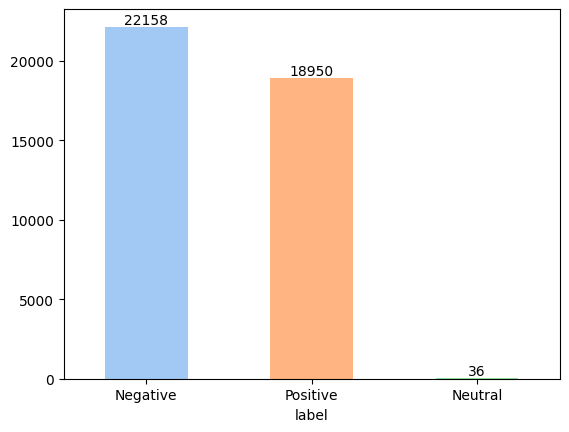

In [11]:
# Plot the value counts as a bar plot
ax = df['label'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

# Add count annotations on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height()}', ha='center', va='bottom')

# Set the x-tick labels
plt.xticks([0, 1, 2], ['Negative', 'Positive', 'Neutral'], rotation=0)

# Show the plot
plt.show()

**Dataset have: **
* **22158**: Negative sentiment
* **18950**: Positive sentiment
* **36**: Neutral sentiment

In [12]:
nltk.download('words')
only_english = set(nltk.corpus.words.words())

# Define a function to clean the text
def clean_text(text):
    # Convert the text to lowercase
    sample = text.lower()

    # Remove URLs
    sample = re.sub(r"\S*https?:\S*", '', sample)

    # Remove text between square brackets
    sample = re.sub('\[.*?\]', '', sample)

    # Remove text between parenthesis
    sample = re.sub('\(.*?\)', '', sample)

    # Remove hashtags
    sample = re.sub('#', ' ', sample)

    # Remove mentions with '@'
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')])

    # Fix contractions like "you're" to "you are"
    sample = " ".join([contractions.fix(x) for x in sample.split()])

    # Remove punctuations
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample)

    # Remove digits with trailing or preceding text
    sample = re.sub('\w*\d\w', '', sample)

    # Remove new line characters
    sample = re.sub(r'\n', ' ', sample)
    sample = re.sub(r'\\n', ' ', sample)

    # Remove quotation marks
    sample = re.sub("[''""...“”‘’…]", '', sample)

    sample = " ".join(x.strip() for x in sample.split())

    # Remove HTML attributes
    sample = re.sub(r', /<[^>]+>/', '', sample)

    # Remove languages other than English
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split())))

    # Remove emojis and symbols
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample)

    sample = sample.strip()

    sample = " ".join([x.strip() for x in sample.split()])

    return sample

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\suren\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [13]:
# Apply clean_text function to each comment in the 'comment' column and create a new column 'cleaned_comment'
df['cleaned_comment'] = df['comment'].apply(lambda x: clean_text(str(x)))

In [14]:
df.sample(5)

,comment,label,cleaned_comment
26407,"Read ""200 Years Together"" by Solzhenitsyn. It ...",P,read years together by solzhenitsyn it denotes...
26501,Has this happened to anyone? I just can't put ...,N,has this happened to anyone i just cannot put ...
4044,what is the point of fucking social distancing?,P,what is the point of fucking social distancing
16610,We Europeans are winning at football competiti...,P,we europeans are winning at football competiti...
19033,"""You sir may have come forth from monkeys but ...",N,you sir may have come forth from monkeys but i...


In [15]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))

# Lemmatization is the process of reducing words to their base or root form.
lemmatizer = WordNetLemmatizer()

# Stemming is the process of reducing words to their stem or root form.
ps = PorterStemmer()

def get_wordnet_pos(word):

    treebank_tag = nltk.pos_tag([word])[0][1]

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text

    sample = text

    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)

    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)

    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)

    if spell:
        sample = str(TextBlob(text).correct())

    return sample

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# creating one more column 'correct_comment' and asign only 'text' for reference
df['correct_comment'] = 'text'
df

,comment,label,cleaned_comment,correct_comment
0,dalits are lowlives,N,dalits are lowlives,text
1,gay people are a burden to our society,N,gay people are a burden to our society,text
2,Arabs are not welcome,N,arabs are not welcome,text
3,I'm not saying we should actually eliminate he...,N,i am not saying we should actually eliminate h...,text
4,bananas are for black people,N,bananas are for black people,text
...,...,...,...,...
41139,Indian culture is so backwards,N,indian culture is so backwards,text
41140,"Women don't want equality, they just want to b...",N,women do not want equality they just want to b...,text
41141,fuck covid,P,fuck covid,text
41142,This computer is garbage,P,this computer is garbage,text


In [17]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
count = 0
# Iterate through each text in the 'cleaned_comment' column of the DataFrame
for text in tqdm(df['cleaned_comment']):
    # Apply the correct_text function with lemma set to True
    df['correct_comment'][count] = correct_text(text, lemma=True)
    # Increment the count variable
    count += 1

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\suren\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\suren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 41144/41144 [06:59<00:00, 98.03it/s] 


In [18]:
# display random 10 rows
df.sample(10)

,comment,label,cleaned_comment,correct_comment
15748,The one single word to describe Sadiq Khan is ...,P,the one single word to describe sadiq khan is ...,one single word describe sadiq khan cunt deriv...
40141,Comments such as women are disgusting should...,P,comments such as women are disgusting should b...,comment woman disgust ban forum
34975,"men are superior to women in every way, especi...",N,men are superior to women in every way especia...,men superior woman every way especially streng...
12868,lmao their marriages are by far the least stab...,P,lmao their marriages are by far the least stab...,lmao marriage far least stable marriage lag wa...
37938,Muslims are lower than rats,N,muslims are lower than rats,muslim low rat
2094,I wish those dumbarses would get whats coming ...,P,i wish those dumbarses would get what is comin...,wish dumbarses would get come would like help
40686,muslims cannot be trusted,N,muslims cannot be trusted,muslim cannot trust
14343,Why don't Max just stay in the kitchen?,P,why do not max just stay in the kitchen,max stay kitchen
30033,An EU review of violence against women reveale...,P,an eu review of violence against women reveale...,eu review violence woman reveal one three euro...
10170,Emma Watson really tried to promote equality f...,N,emma watson really tried to promote equality f...,emma watson really try promote equality heshes...


In [19]:
# drop the comment and cleaned_comment columns for df_final dataset
df_final = df.drop(columns = ['comment', 'cleaned_comment'], axis=1)

In [20]:
df_final.sample(5)

,label,correct_comment
12487,P,everytime see peedo treat like shit cough bitc...
39336,N,want join cult christian
2625,N,kanye west give u pas n ggas paris say anyway
36363,P,n people
9248,P,tell twat jagoffs


In [23]:
# save the clean data into hate_cleaned.csv
df_final.to_csv(r"C:\Users\suren\Downloads\NLP for Sentiment Analysis\Dataset\hate_cleaned.csv", index=False)

In [24]:
df_final.shape

(41144, 2)

In [25]:
# changing the targert label value in integer label
label_mapping = {'N': 0, 'P': 1, 'O': 2}

df_final['label'] = df_final['label'].replace(label_mapping)

In [26]:
df_final.sample(5)

,label,correct_comment
34742,0,mozzies live another century
29760,1,time blame colonialism displace every poor exp...
3407,0,recognise refugee dismissive attitude
7811,1,must hard every fuck day asylum seeker
32901,0,still discus jew condemn thought action withou...


In [27]:
# unique vlaues in label column After changing label from dataset label column
df_final['label'].unique()

array([0, 1, 2], dtype=int64)

## Model Eveluation

In [28]:
# distribute the target and feature column in X, y
X = df_final['correct_comment']
y = df_final['label']

In [29]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [32]:
feature_extraction = TfidfVectorizer()

X_train_features = feature_extraction.fit_transform(X_train)
X_test_features  = feature_extraction.transform(X_test)

# converting y_train and y_test values as integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [33]:
logisticRegressionModel = LogisticRegression()

In [34]:
logisticRegressionModel.fit(X_train_features, y_train)
prediction_on_training_data = logisticRegressionModel.predict(X_train_features)
accuracy_on_training_data = accuracy_score(y_train, prediction_on_training_data)

In [35]:
print("Training Accuracy score: ", accuracy_on_training_data*100)

Training Accuracy score:  79.19791666666667


In [36]:
logisticRegressionModel.fit(X_test_features, y_test)
prediction_on_test_data = logisticRegressionModel.predict(X_test_features)
accuracy_on_test_data = accuracy_score(y_test, prediction_on_test_data)

In [37]:
print("Test Accuracy score: ", accuracy_on_training_data*100)

Test Accuracy score:  79.19791666666667


In [38]:
X_test

40554          nothing love see horrible black get oppress
6580                          arepas one reason world suck
10304    many people cannot stand united kingdom exampl...
14542    tough dude girlfriend switch lot sex even ente...
11764    next big bout take place see go win fight many...
                               ...                        
20357    tranny transphobic slur use demean insult tran...
41123                                   would trust indian
19467                                                 iran
23495                                think zionist scammer
6408                            fuck leeds ruin everything
Name: correct_comment, Length: 12344, dtype: object

In [39]:
y_test

40554    0
6580     1
10304    1
14542    0
11764    0
        ..
20357    1
41123    0
19467    0
23495    0
6408     1
Name: label, Length: 12344, dtype: int32

In [40]:
# testing manualy
input_mail = ["arepas one reason world suck"]

# converting text into feature vectore
input_data_features = feature_extraction.transform(input_mail)

prediction = logisticRegressionModel.predict(input_data_features)
print(prediction)

if prediction[0] == 0:
  print("Negative Sentiment")
elif prediction[0] == 1:
  print("Positive Sentiment")
else:
  print("Neutral Sentiment")

[1]
Positive Sentiment


In [60]:
# Saving the model
joblib.dump(logisticRegressionModel, "logisticRegModel.joblib")

['logisticRegModel.joblib']

In [41]:
joblib.dump(feature_extraction, "tfidf_vectorizer.joblib")

['tfidf_vectorizer.joblib']